# Endoscopy Access Visualisation by LSOA

This notebook visualises spatial access to endoscopy services across the South West region, focusing on population aged 50 and over, and capacity measured as endoscopy rooms per 100,000 people.

1. Load spatial population data (age 50+) and endoscopy site capacity data (CDC, Acute, and optionally Community Hospitals)
2. Classify and visualise each site’s access level using thresholds:
   - Under 3.5 rooms per 100k aged 50+ → Low access
   - 3.5 to 3.9 rooms → Marginal access
   - 4.0 and above → Adequate access
3. Visualise 50+ population distribution as a choropleth map
4. Overlay travel time bands and site locations to assess geographic inequalities
5. Prepare a base for incorporating LSOA-to-LSOA travel time matrices for accessibility scoring, catchment analysis, and future scenario testing (e.g., new room or site additions)


In [1]:
# ----------------------------------------------------------
# Step 0 – Imports, File Paths, and Script Path Setup
# ----------------------------------------------------------
import os
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Optional for warnings
import warnings
warnings.filterwarnings("ignore")

# Add custom script directory if needed
script_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/scripts"
if script_dir not in sys.path:
    sys.path.append(script_dir)

# Define base data directory
data_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw"
modality_dir = os.path.join(data_dir, "modality_modelling")

# File paths
gpkg_path = os.path.join(data_dir, "LSOA_5-year_segment_master.gpkg")
travel_csv_path = os.path.join(data_dir, "LSOA_to_LSOA_complete.csv")
modality_counts_path = os.path.join(data_dir, "modality_procedure_counts_by_age_band_2024.csv")
cdc_path = os.path.join(modality_dir, "NHS_SW_ Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(modality_dir, "NHS_SW_Acute_Hospitals_Capability.csv")

# Placeholder for community hospital file
# community_path = os.path.join(modality_dir, "NHS_SW_Community_Hospitals_Capability.csv")  # To be added


In [2]:
# ----------------------------------------------------------
# Step 1 – Load and Prepare Travel Matrix, Facilities, and Population
# ----------------------------------------------------------

# Load travel matrix
travel_df = pd.read_csv(travel_csv_path).rename(columns={
    "origin_name": "origin_lsoa",
    "destination_name": "dest_lsoa",
    "travel_time_car": "car_travel_minutes",
    "travel_time_pt_peak": "pt_peak_minutes",
    "travel_time_pt_nonpeak": "pt_nonpeak_minutes"
})

# Clean travel matrix
travel_df["car_travel_minutes"] = pd.to_numeric(travel_df["car_travel_minutes"], errors="coerce")
travel_df["origin_lsoa"] = travel_df["origin_lsoa"].astype(str)
travel_df["dest_lsoa"] = travel_df["dest_lsoa"].astype(str)

# Load LSOA population data
gdf_pop = gpd.read_file(gpkg_path)
gdf_pop["lsoa21cd"] = gdf_pop["lsoa21cd"].astype(str)

# Compute population aged 50+
gdf_pop["population_50_plus"] = gdf_pop[[
    "age_50_54", "age_55_59", "age_60_64", "age_65_69",
    "age_70_74", "age_75_79", "age_80_84", "age_85_plus"
]].sum(axis=1)

# Load CDC and Acute hospital data
cdc_df = pd.read_csv(cdc_path)
acute_df = pd.read_csv(acute_path)

# Standardise facility data
facility_cols = ["Name", "lsoa21cd", "Endoscopy Rooms"]
cdc_df = cdc_df[facility_cols].assign(facility_type="CDC")
acute_df = acute_df[facility_cols].assign(facility_type="Acute")

# Combine facilities and drop missing LSOAs or 0-room entries
facilities_df = pd.concat([cdc_df, acute_df], ignore_index=True)
facilities_df = facilities_df.dropna(subset=["lsoa21cd"])
facilities_df = facilities_df[facilities_df["Endoscopy Rooms"] > 0].copy()
facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)


In [3]:
# ----------------------------------------------------------
# Step 2 – Build Clean Travel, Facility, and Population DataFrames
# ----------------------------------------------------------

# --- 2.1: Travel Times ---
travel_df = pd.read_csv(travel_csv_path)

# Clean column names and types
travel_df = travel_df.rename(columns={
    "origin_name": "origin_lsoa",
    "destination_name": "dest_lsoa",
    "travel_time_car": "car_travel_minutes",
    "travel_time_pt_peak": "pt_peak_minutes",
    "travel_time_pt_nonpeak": "pt_nonpeak_minutes"
})
travel_df["origin_lsoa"] = travel_df["origin_lsoa"].astype(str)
travel_df["dest_lsoa"] = travel_df["dest_lsoa"].astype(str)

# Keep relevant columns
travel_df = travel_df[[
    "origin_lsoa", "dest_lsoa", "car_travel_minutes",
    "pt_peak_minutes", "pt_nonpeak_minutes"
]].copy()

# --- 2.2: Facility Locations (CDC + Acute) ---
cdc_df = pd.read_csv(cdc_path)
acute_df = pd.read_csv(acute_path)

# Standardise and combine
facilities_df = pd.concat([
    cdc_df.assign(facility_type="CDC"),
    acute_df.assign(facility_type="Acute")
], ignore_index=True)

# Clean and keep only relevant facility rows
facilities_df = facilities_df.dropna(subset=["lsoa21cd", "Endoscopy Rooms"])
facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# Final facility fields
facilities_df = facilities_df[[
    "Name", "lsoa21cd", "Endoscopy Rooms", "facility_type"
]].drop_duplicates()

# --- 2.3: Population 50+ per LSOA ---
# Load geospatial population data
gdf_pop = gpd.read_file(gpkg_path)

# Sum all age bands 50+
gdf_pop["population_50_plus"] = gdf_pop[
    ["age_50_54", "age_55_59", "age_60_64", "age_65_69",
     "age_70_74", "age_75_79", "age_80_84", "age_85_plus"]
].sum(axis=1)

# Extract for merging
population_df = gdf_pop[["lsoa21cd", "population_50_plus"]].copy()
population_df = population_df.rename(columns={"lsoa21cd": "origin_lsoa"})
population_df["origin_lsoa"] = population_df["origin_lsoa"].astype(str)

# Preview samples
print("\n--- travel_df sample ---")
display(travel_df.head())

print("\n--- facilities_df sample ---")
display(facilities_df.head())

print("\n--- population_df sample ---")
display(population_df.head())



--- travel_df sample ---


,origin_lsoa,dest_lsoa,car_travel_minutes,pt_peak_minutes,pt_nonpeak_minutes
0,E01022150,E01014950,42.748168,56.288168,56.288168
1,E01029238,E01033364,85.033922,126.483922,126.483922
2,E01014654,E01015202,123.315531,148.025531,146.985531
3,E01015028,E01029066,133.568645,268.518645,255.878645
4,E01015316,E01029066,112.233260,221.623260,227.623260



--- facilities_df sample ---


,Name,lsoa21cd,Endoscopy Rooms,facility_type
0,Bsw Banes Locality CDC,E01014444,3,CDC
1,Salisbury CDC,E01032014,0,CDC
2,West Swindon CDC,E01015569,0,CDC
3,Weston CDC,E01014833,0,CDC
4,North Bristol CDC,E01014861,3,CDC



--- population_df sample ---


,origin_lsoa,population_50_plus
0,E01020484,764.21
1,E01020481,893.46
2,E01020482,805.95
3,E01020479,789.67
4,E01020478,652.28


In [4]:
# Drop facilities with 0 or missing endoscopy rooms
facilities_df = facilities_df.dropna(subset=["Endoscopy Rooms"])
facilities_df = facilities_df[facilities_df["Endoscopy Rooms"] > 0].copy()


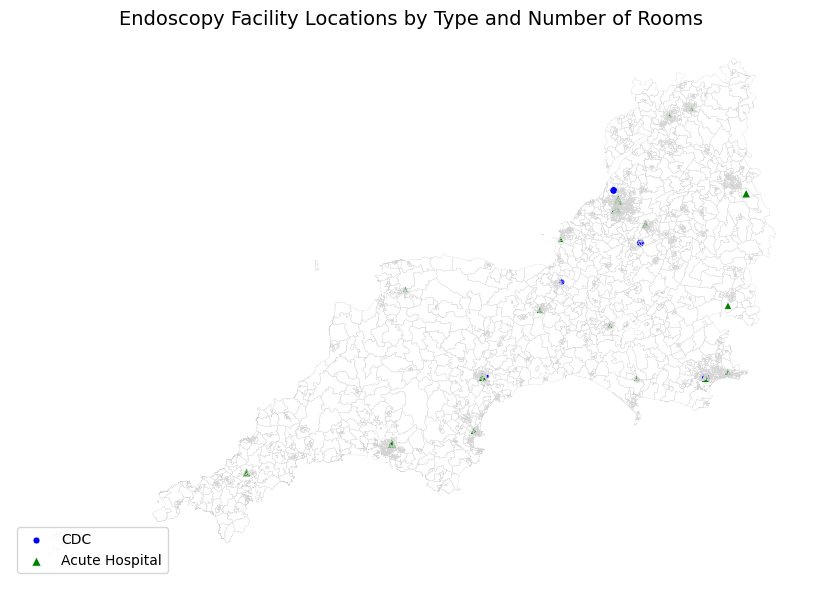

In [8]:
# ------------------------------------------------------------------
# Step 3 – Visualise Endoscopy Facility Locations (Capacity-Scaled)
# ------------------------------------------------------------------

# 3.1 – Load LSOA geometry for facility mapping
gdf_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]

# 3.2 – Clean and prepare facilities
facilities_df = facilities_df.dropna(subset=["Endoscopy Rooms"])
facilities_df = facilities_df[facilities_df["Endoscopy Rooms"] > 0].copy()
facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# 3.3 – Merge facilities with LSOA geometries
facilities_gdf = facilities_df.merge(gdf_geom, on="lsoa21cd", how="left")
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_geom.crs)

# Replace geometry with centroid for plotting (point location)
facilities_gdf["geometry"] = facilities_gdf["geometry"].centroid

# 3.4 – Split into CDC and Acute subsets
cdc_gdf = facilities_gdf[facilities_gdf["facility_type"] == "CDC"].copy()
acute_gdf = facilities_gdf[facilities_gdf["facility_type"] == "Acute"].copy()

# 3.5 – Plot endoscopy sites scaled by room count
fig, ax = plt.subplots(figsize=(10, 6))

# Plot base LSOA boundaries
gdf_geom.boundary.plot(ax=ax, linewidth=0.2, color='lightgrey')

# Plot CDCs with blue circle markers
cdc_gdf.plot(
    ax=ax,
    color="blue",
    markersize=cdc_gdf["Endoscopy Rooms"] * 10,  # scale as needed
    label="CDC",
    marker="o",
    edgecolor="white",
    linewidth=0.5
)

# Plot Acute hospitals with green triangle markers
acute_gdf.plot(
    ax=ax,
    color="green",
    markersize=acute_gdf["Endoscopy Rooms"] * 10,
    label="Acute Hospital",
    marker="^",
    edgecolor="white",
    linewidth=0.5
)

# Final formatting
ax.set_title("Endoscopy Facility Locations by Type and Number of Rooms", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

plt.tight_layout()
plt.savefig("endoscopy_facilities_scaled_overlay.png", dpi=300, bbox_inches="tight")
plt.show()


In [6]:
# Preview all valid facilities after cleaning (rooms > 0)
facilities_summary = facilities_df[[
    "Name", "lsoa21cd", "Endoscopy Rooms", "facility_type"
]].sort_values(by="Endoscopy Rooms", ascending=False).reset_index(drop=True)

# Show the full list (or limit rows with .head(n) if needed)
display(facilities_summary)


,Name,lsoa21cd,Endoscopy Rooms,facility_type
0,Bristol Royal Infirmary,E01033904,7,Acute
1,Southmead Hospital,E01014632,6,Acute
2,Derriford Hospital,E01015092,5,Acute
3,Royal Devon & Exeter Hospital (Wonford),E01020013,5,Acute
4,Royal United Hospital,E01014428,4,Acute
5,Royal Cornwall Hospital (Treliske),E01034862,4,Acute
6,Dorset Health Village Poole CDC,E01034281,4,CDC
7,Poole Hospital,E01034281,4,Acute
8,The Great Western Hospital,E01015547,4,Acute
9,Royal Bournemouth Hospital,E01015319,3,Acute


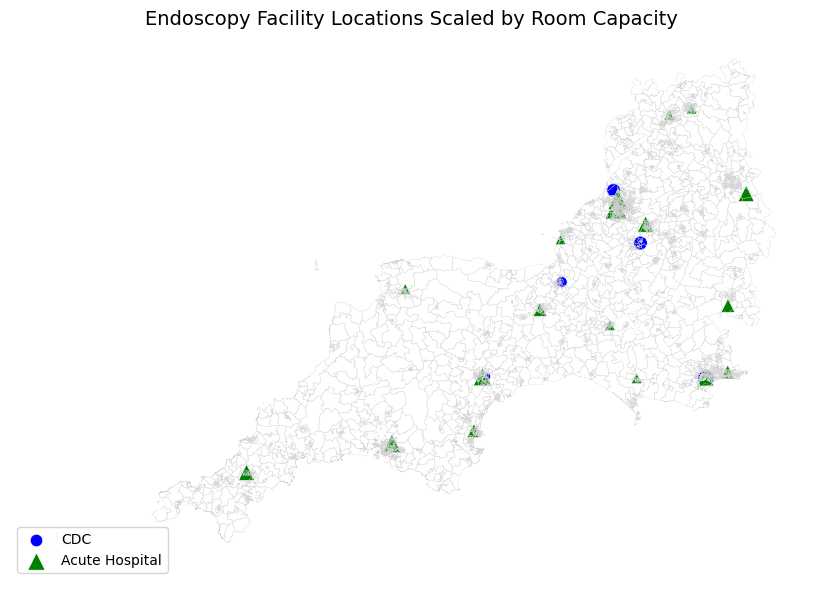

In [9]:
# ------------------------------------------------------------------
# Step 3 – Visualise Endoscopy Facility Locations (Smoothed Size)
# ------------------------------------------------------------------

import numpy as np

# 3.1 – Load LSOA geometry for facility mapping
gdf_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]

# 3.2 – Clean and prepare facilities
facilities_df = facilities_df.dropna(subset=["Endoscopy Rooms"])
facilities_df = facilities_df[facilities_df["Endoscopy Rooms"] > 0].copy()
facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# 3.3 – Merge with geometry
facilities_gdf = facilities_df.merge(gdf_geom, on="lsoa21cd", how="left")
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_geom.crs)
facilities_gdf["geometry"] = facilities_gdf["geometry"].centroid

# 3.4 – Smooth marker size: min-max scaling to 25–250
min_size = 25
max_size = 250
rooms = facilities_gdf["Endoscopy Rooms"]
scaled_size = min_size + (rooms - rooms.min()) / (rooms.max() - rooms.min()) * (max_size - min_size)
facilities_gdf["marker_size"] = scaled_size

# 3.5 – Split by type
cdc_gdf = facilities_gdf[facilities_gdf["facility_type"] == "CDC"].copy()
acute_gdf = facilities_gdf[facilities_gdf["facility_type"] == "Acute"].copy()

# 3.6 – Plot
fig, ax = plt.subplots(figsize=(10, 6))
gdf_geom.boundary.plot(ax=ax, linewidth=0.2, color='lightgrey')

# CDCs
cdc_gdf.plot(
    ax=ax,
    color="blue",
    markersize=cdc_gdf["marker_size"],
    label="CDC",
    marker="o",
    edgecolor="white",
    linewidth=0.5
)

# Acute hospitals
acute_gdf.plot(
    ax=ax,
    color="green",
    markersize=acute_gdf["marker_size"],
    label="Acute Hospital",
    marker="^",
    edgecolor="white",
    linewidth=0.5
)

# Format
ax.set_title("Endoscopy Facility Locations Scaled by Room Capacity", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

plt.tight_layout()
plt.savefig("endoscopy_facilities_scaled_overlay_smoothed.png", dpi=300, bbox_inches="tight")
plt.show()


In [11]:
# Total number of valid facilities (already filtered for rooms > 0)
total_facilities = len(facilities_df)

# Total number of endoscopy rooms across all valid facilities
total_rooms = facilities_df["Endoscopy Rooms"].sum()

# Total population aged 50+
total_pop_50_plus = population_df["population_50_plus"].sum()

# Ratios
facilities_per_100k = (total_facilities / total_pop_50_plus) * 100_000
rooms_per_100k = (total_rooms / total_pop_50_plus) * 100_000

# Print summary
print(f"Total valid facilities: {total_facilities}")
print(f"Total endoscopy rooms: {total_rooms}")
print(f"Total 50+ population: {total_pop_50_plus:,.0f}")
print(f"\nFacilities per 100,000 aged 50+: {facilities_per_100k:.2f}")
print(f"Rooms per 100,000 aged 50+: {rooms_per_100k:.2f}")


Total valid facilities: 25
Total endoscopy rooms: 78
Total 50+ population: 2,516,361

Facilities per 100,000 aged 50+: 0.99
Rooms per 100,000 aged 50+: 3.10


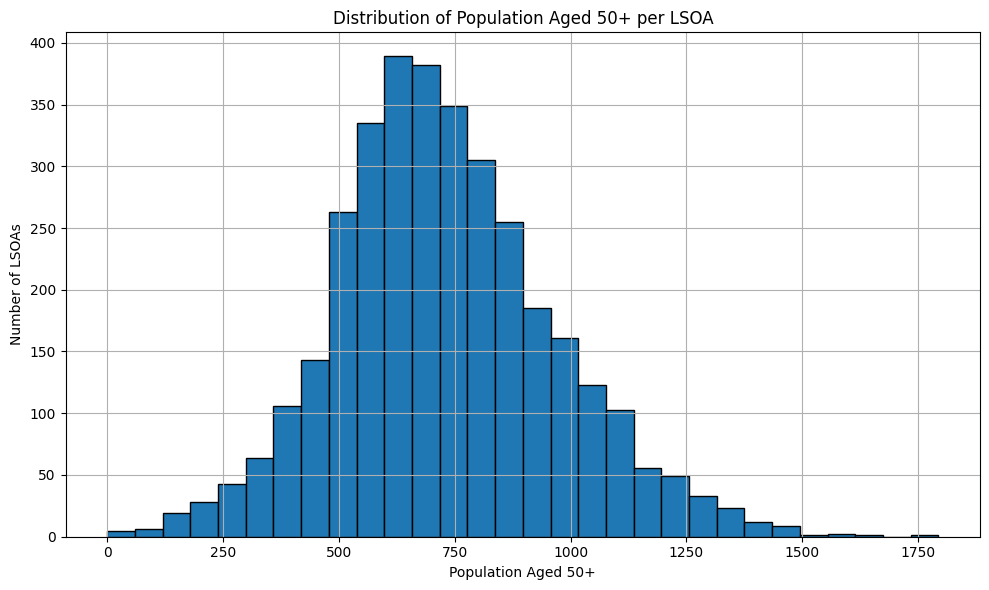

Min: 0.0
Max: 1794.03
Quantiles:
0.05     364.305
0.25     570.865
0.50     709.260
0.75     869.030
0.95    1150.400
Name: population_50_plus, dtype: float64


In [12]:
import matplotlib.pyplot as plt

# Plot histogram of population aged 50+ per LSOA
plt.figure(figsize=(10, 6))
plt.hist(population_df["population_50_plus"], bins=30, edgecolor='black')
plt.title("Distribution of Population Aged 50+ per LSOA")
plt.xlabel("Population Aged 50+")
plt.ylabel("Number of LSOAs")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Print min, max, and quantiles
print("Min:", population_df["population_50_plus"].min())
print("Max:", population_df["population_50_plus"].max())
print("Quantiles:")
print(population_df["population_50_plus"].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))


In [13]:
# Define bins and labels
bins = [0, 364, 571, 869, 1150, float("inf")]
labels = ["Very Low", "Low", "Medium", "High", "Very High"]

# Add tier column
population_df["demand_tier"] = pd.cut(
    population_df["population_50_plus"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
)

# Quick check
print(population_df["demand_tier"].value_counts().sort_index())


demand_tier
Very Low      172
Low           696
Medium       1717
High          693
Very High     173
Name: count, dtype: int64


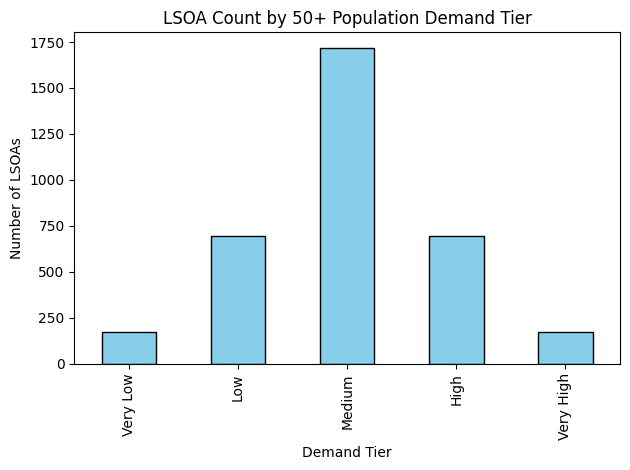

In [14]:
population_df["demand_tier"].value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black"
)
plt.title("LSOA Count by 50+ Population Demand Tier")
plt.xlabel("Demand Tier")
plt.ylabel("Number of LSOAs")
plt.tight_layout()
plt.show()


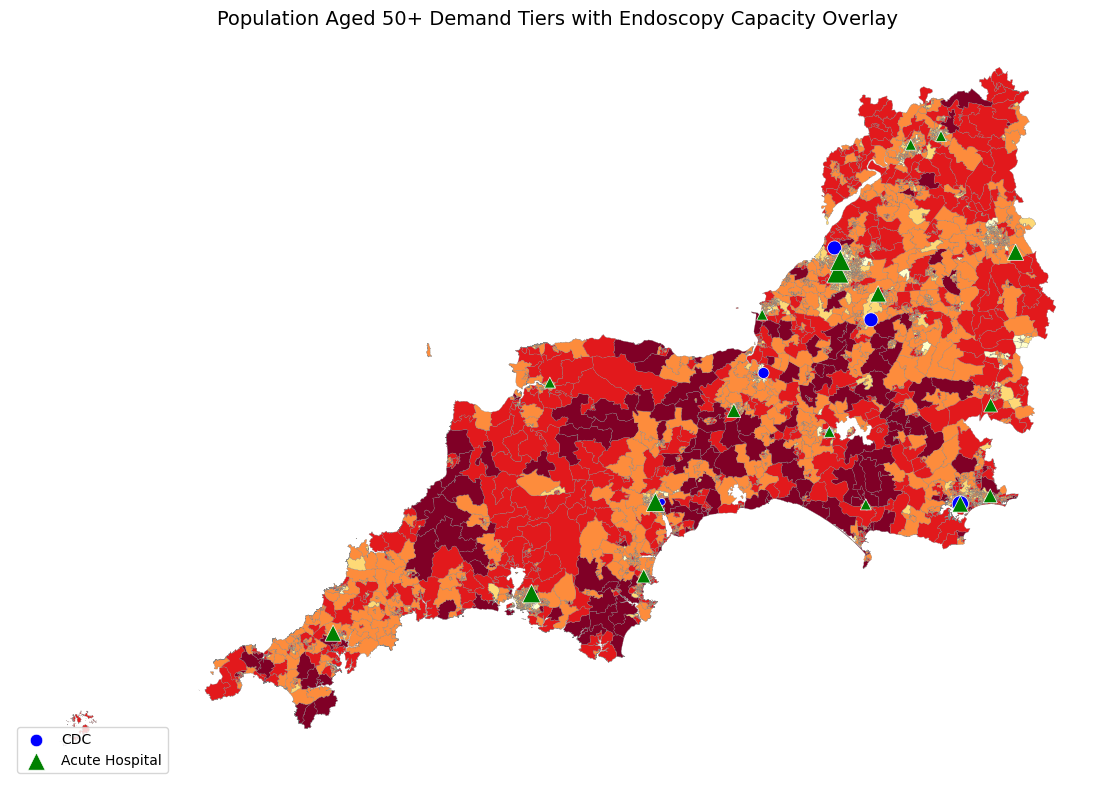

In [15]:
# ------------------------------------------------------------------
# Step 4 – Choropleth of 50+ Demand Tiers + Facility Overlay
# ------------------------------------------------------------------

# 4.1 – Merge geometry with demand tiers
gdf_demand = gdf_geom.merge(
    population_df[["origin_lsoa", "demand_tier"]],
    left_on="lsoa21cd",
    right_on="origin_lsoa",
    how="left"
)

# Drop rows with no demand tier (e.g., missing pop data)
gdf_demand = gdf_demand.dropna(subset=["demand_tier"]).copy()

# 4.2 – Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot LSOA demand tier choropleth
gdf_demand.plot(
    column="demand_tier",
    cmap="YlOrRd",  # Yellow → Orange → Red
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    legend_kwds={"title": "50+ Population Demand Tier"},
    ax=ax
)

# Overlay CDCs
cdc_gdf.plot(
    ax=ax,
    color="blue",
    markersize=cdc_gdf["marker_size"],
    label="CDC",
    marker="o",
    edgecolor="white",
    linewidth=0.5
)

# Overlay Acute Hospitals
acute_gdf.plot(
    ax=ax,
    color="green",
    markersize=acute_gdf["marker_size"],
    label="Acute Hospital",
    marker="^",
    edgecolor="white",
    linewidth=0.5
)

# Final formatting
ax.set_title("Population Aged 50+ Demand Tiers with Endoscopy Capacity Overlay", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

plt.tight_layout()
plt.savefig("endoscopy_demand_tiers_with_capacity_overlay.png", dpi=300, bbox_inches="tight")
plt.show()


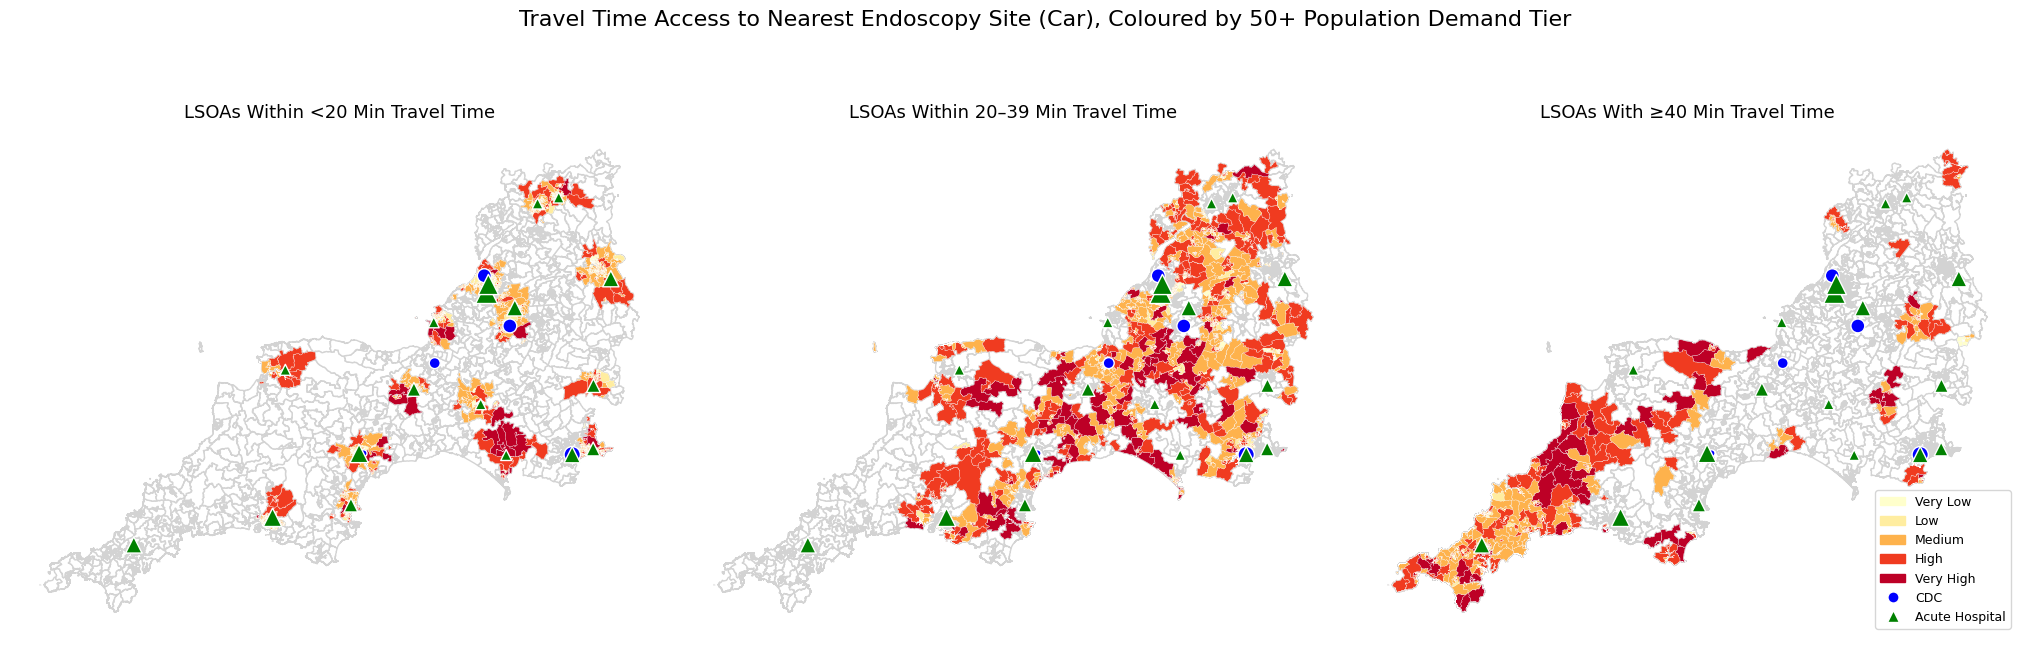

In [22]:
# ------------------------------------------------------------------
# Step 5 – 3 Travel Time Band Maps (with 5-Tier Demand Colours)
# ------------------------------------------------------------------

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

# 5.0 – Ensure valid facilities (already done earlier)
facilities_summary = facilities_df[[
    "Name", "lsoa21cd", "Endoscopy Rooms", "facility_type"
]].sort_values(by="Endoscopy Rooms", ascending=False).reset_index(drop=True)

# 5.1 – Compute travel time to nearest valid facility per origin LSOA
facility_lsoas = facilities_summary["lsoa21cd"].unique()

# Filter to facility destinations only
travel_to_facilities = travel_df[travel_df["dest_lsoa"].isin(facility_lsoas)].copy()

# Recompute minimum travel time
nearest_travel_df = travel_to_facilities.groupby("origin_lsoa", as_index=False)["car_travel_minutes"].min()
nearest_travel_df = nearest_travel_df.rename(columns={"car_travel_minutes": "travel_to_nearest_mins"})

# 5.2 – Merge geometry + population demand + travel time
gdf_merged = gdf_geom.merge(
    population_df[["origin_lsoa", "population_50_plus", "demand_tier"]],
    left_on="lsoa21cd",
    right_on="origin_lsoa",
    how="left"
).merge(
    nearest_travel_df,
    left_on="lsoa21cd",
    right_on="origin_lsoa",
    how="left"
)

# 5.3 – Drop rows with missing values
gdf_merged = gdf_merged.dropna(subset=["demand_tier", "travel_to_nearest_mins"]).copy()

# 5.4 – Ensure demand_tier is ordered categorical
tier_order = ["Very Low", "Low", "Medium", "High", "Very High"]
tier_palette_dict = {
    "Very Low": "#ffffcc",
    "Low": "#ffeda0",
    "Medium": "#feb24c",
    "High": "#f03b20",
    "Very High": "#bd0026"
}
tier_palette = [tier_palette_dict[t] for t in tier_order]
gdf_merged["demand_tier"] = pd.Categorical(gdf_merged["demand_tier"], categories=tier_order, ordered=True)

# 5.5 – Define travel bands
lt_20 = gdf_merged[gdf_merged["travel_to_nearest_mins"] < 20].copy()
btw_20_39 = gdf_merged[(gdf_merged["travel_to_nearest_mins"] >= 20) & (gdf_merged["travel_to_nearest_mins"] < 40)].copy()
gt_40 = gdf_merged[gdf_merged["travel_to_nearest_mins"] >= 40].copy()

lt_20["demand_tier"] = pd.Categorical(lt_20["demand_tier"], categories=tier_order, ordered=True)
btw_20_39["demand_tier"] = pd.Categorical(btw_20_39["demand_tier"], categories=tier_order, ordered=True)
gt_40["demand_tier"] = pd.Categorical(gt_40["demand_tier"], categories=tier_order, ordered=True)

# 5.6 – Plot settings
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

plot_kwargs = dict(
    column="demand_tier",
    edgecolor="white",
    linewidth=0.2,
    cmap=ListedColormap(tier_palette),
    legend=False
)

# Plot 1 – <20 mins
gdf_merged.assign(dummy=False).plot(ax=axes[0], color="white", edgecolor="lightgrey")
lt_20.plot(ax=axes[0], **plot_kwargs)
cdc_gdf.plot(ax=axes[0], color="blue", markersize=cdc_gdf["marker_size"], marker="o", edgecolor="white", label="CDC")
acute_gdf.plot(ax=axes[0], color="green", markersize=acute_gdf["marker_size"], marker="^", edgecolor="white", label="Acute")
axes[0].set_title("LSOAs Within <20 Min Travel Time", fontsize=13)
axes[0].axis("off")

# Plot 2 – 20–39 mins
gdf_merged.assign(dummy=False).plot(ax=axes[1], color="white", edgecolor="lightgrey")
btw_20_39.plot(ax=axes[1], **plot_kwargs)
cdc_gdf.plot(ax=axes[1], color="blue", markersize=cdc_gdf["marker_size"], marker="o", edgecolor="white")
acute_gdf.plot(ax=axes[1], color="green", markersize=acute_gdf["marker_size"], marker="^", edgecolor="white")
axes[1].set_title("LSOAs Within 20–39 Min Travel Time", fontsize=13)
axes[1].axis("off")

# Plot 3 – ≥40 mins
gdf_merged.assign(dummy=False).plot(ax=axes[2], color="white", edgecolor="lightgrey")
gt_40.plot(ax=axes[2], **plot_kwargs)
cdc_gdf.plot(ax=axes[2], color="blue", markersize=cdc_gdf["marker_size"], marker="o", edgecolor="white")
acute_gdf.plot(ax=axes[2], color="green", markersize=acute_gdf["marker_size"], marker="^", edgecolor="white")
axes[2].set_title("LSOAs With ≥40 Min Travel Time", fontsize=13)
axes[2].axis("off")

# 5.7 – Shared legend
tier_handles = [
    mpatches.Patch(color=tier_palette_dict[tier], label=tier) for tier in tier_order
]
site_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='CDC',
               markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='^', color='w', label='Acute Hospital',
               markerfacecolor='green', markersize=8)
]

axes[2].legend(handles=tier_handles + site_handles, loc='lower right', frameon=True, fontsize=9)

# 5.8 – Final layout
plt.suptitle("Travel Time Access to Nearest Endoscopy Site (Car), Coloured by 50+ Population Demand Tier", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.97, 0.95])
plt.savefig("travel_time_3band_demandtier_overlay.png", dpi=300, bbox_inches="tight")
plt.show()


In [23]:
print("LSOAs with travel time ≥ 20 mins:", (gdf_merged["travel_to_nearest_mins"] >= 20).sum())
print("LSOAs with travel time ≥ 40 mins:", (gdf_merged["travel_to_nearest_mins"] >= 40).sum())


LSOAs with travel time ≥ 20 mins: 1803
LSOAs with travel time ≥ 40 mins: 470
